# for word2vec:
https://towardsdatascience.com/implementing-word2vec-in-pytorch-skip-gram-model-e6bae040d2fb
# for transD:
https://github.com/jimmywangheng/knowledge_representation_pytorch/
# for RNN:
https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

In [1]:
from collections import defaultdict, Counter
import networkx as nx
import numpy as np
import pylab as plt
import random
import torch
import torch.nn as nn
from copy import deepcopy
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable

# RNN

In [2]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, input_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output, hidden = self.gru(embedded, hidden)
        output = self.out(output[0]) 
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size)
    
def oneHot(idx):
    x = torch.zeros(10).float()
    x[idx] = 1.0
    return x

def tensorsFromPair(pair):
    input_tensor = torch.tensor(pair[0], dtype=torch.long).view(-1, 1)
    target_tensor = torch.tensor(pair[1], dtype=torch.long).view(-1, 1)
    return (input_tensor, target_tensor)

In [3]:
# order is compressed and passed from input sequence to output sequence

class EncoderRNN_(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN_, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, current_input_element_index, order):
        # here I call hidden "order" because it comressed the order of the input sequences
        current_input_element_embedded = self.embedding(current_input_element_index).view(1, 1, -1)
        current_input_element_wasted, compressed_order = self.gru(current_input_element_embedded, order)
        return current_input_element_wasted, compressed_order

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size)
    
class DecoderRNN_(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN_, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, last_output_element_index, order):# starting for SOS
        last_output_element_embedded = self.embedding(last_output_element_index).view(1, 1, -1)
        last_output_element_embedded = F.relu(last_output_element_embedded)#only keep positive
        current_output_element_embedded, decompressed_order = self.gru(last_output_element_embedded, order)
        current_output_element_predicted = self.softmax(self.out(current_output_element_embedded[0]))
        return current_output_element_predicted, decompressed_order

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size)

In [4]:
SOS_token = 0
input_size, hidden_size, output_size=(10,2,10)# 0 is SOS, both input and output sequences starts from SOS
n_iters = 100
encoder = EncoderRNN_(input_size, hidden_size)
decoder = DecoderRNN_(hidden_size, output_size)
learning_rate = 0.05
encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
order = encoder.initHidden()
criterion = nn.NLLLoss()
#
input_data=list(zip(range(1,9),range(2,10)))
output_data=list(zip(range(10,90,10),range(20,100,10)))
pairs= list(zip(input_data,output_data))
outputToIndex={v:k for k,v in enumerate([0]+[i for i in range(10,100,10)])}
inv_outputToIndex = {v: k for k, v in outputToIndex.items()}


In [5]:
pairs

[((1, 2), (10, 20)),
 ((2, 3), (20, 30)),
 ((3, 4), (30, 40)),
 ((4, 5), (40, 50)),
 ((5, 6), (50, 60)),
 ((6, 7), (60, 70)),
 ((7, 8), (70, 80)),
 ((8, 9), (80, 90))]

In [6]:
Loss=[]
for epoch in range(500):
    training_pairs = [tensorsFromPair(pair) for pair in pairs]
    a=0
    for input_tensor,target_tensor in training_pairs:
        loss=0
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        input_length = input_tensor.size(0)
        target_length = target_tensor.size(0)
        
        for ei in range(input_length):
            current_input_element_wasted, order= encoder(input_tensor[ei], order)
            
        decoder_input = torch.tensor([[SOS_token]])
        
        for di in range(target_length):
            current_output_element_predicted, order= decoder(decoder_input, order)
            topv, topi = current_output_element_predicted.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input
            target=torch.tensor(outputToIndex[target_tensor[di].item()], dtype=torch.long).view(-1, 1)[0]
            loss += criterion(current_output_element_predicted, target)

        loss.backward(retain_graph=True)
        encoder_optimizer.step()
        decoder_optimizer.step()
        a+=loss.item()
        
    Loss.append(a/n_iters)
    if epoch%50==0:
        print(epoch, a/n_iters)

0 0.3804517364501953
50 0.22074283361434938
100 0.15192389369010925
150 0.12909251928329468
200 0.10468120813369751
250 0.09074642658233642


KeyboardInterrupt: 

Text(0, 0.5, 'Loss')

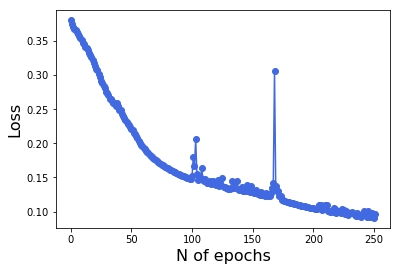

In [7]:
plt.plot(Loss,color='RoyalBlue',marker='o')
plt.xlabel('N of epochs',fontsize=16)
plt.ylabel('Loss',fontsize=16)

In [8]:
for k,v in pairs:
    input_tensor,target_tensor=tensorsFromPair((k,v))
    for ei in range(input_length):
        current_input_element_wasted, order= encoder(input_tensor[ei], order)
    decoder_input = torch.tensor([[SOS_token]])
    predictates=[]
    for di in range(2):
        current_output_element_predicted, order= decoder(decoder_input, order)
        topv, topi = current_output_element_predicted.topk(1)
        predictates.append(inv_outputToIndex[topi.item()])
        decoder_input = topi.squeeze().detach()  # detach from history as input
    print(k,v,'predicted: '+str(predictates))

(1, 2) (10, 20) predicted: [20, 20]
(2, 3) (20, 30) predicted: [20, 30]
(3, 4) (30, 40) predicted: [30, 40]
(4, 5) (40, 50) predicted: [40, 50]
(5, 6) (50, 60) predicted: [50, 60]
(6, 7) (60, 70) predicted: [60, 70]
(7, 8) (70, 80) predicted: [70, 80]
(8, 9) (80, 90) predicted: [80, 80]


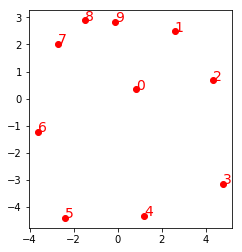

In [10]:
pos=dict(zip(range(10),decoder.out.weight.data.numpy()))
fig = plt.figure(figsize=(8, 4),facecolor='white')
ax = fig.add_subplot(121)
for i in pos:
    x,y=pos[i]
    plt.plot(x,y,marker='o',color='r')
    plt.text(x,y,i,size=14,color='r')